# Find the Needle in the Graphstack

## Bayesian Score

In order to complete this task, a Bayesian scoring function had to be constructed.  This scoring function would be utilized to evaluate how well the graph constructed fit the data provided.

My implementation of the scoring function broke the process down into two separate functions.  The first, `count_func()` used the DAG to be scored and the data set to construct the $m_{ijk}$ vars by counting the number of parental instantiations of each node.  The `networkx` package identifies predecessors for every node in the graph.

The list returned by `count_func()` was the input for `score_func()` which calculated the Bayes Score for the graph.  The an arrays of 1 in the dimension of the each $m$ array of counted data was created as $a_{ijk} = 1$ with the assumption of a uniform prior.  The `gammaln()` function was used to calculate the loggamma of summed components and the Bayes score was updated at the completion of each loop.

## Search Method

My search method utilizes a local directed graph search technique.  The search function, `neighbor_search()` begins with a completely unconnected graph and randomly assigns a connection.  From that point, it selects a random node and classifies all other nodes in the graph as parents, children or unconnected.  If parent or child, it will test removal and reversing the connection.  If unconnected, it will test both parent and child relationship. After the entire neighborhood is scored, it will make the connection with the highest Bayes score and repeat this process.  When a cyclic graph is created, a score of $-\inf$ is assigned so that connection is not selected.  It conducts this in a loop until there it arrives at a local maximum then exits.

As this is computationally expensive for larger graphs, I incorporated the search function into a loop where it will iterate off of the best developed graph while removing between 10-25% of existing connections and initiating the search with that graph.

## Results

While the search seemed to find relatively good results (15th out of 58 place overall: T-2nd small/ 12th med/ 14th large at the time of writing) the time taken in the large dataset seems excessive.  I would be interested to see how it compares to other search methods, but I think the computational time could be improved in my technique.  The statistics on a single pass of `neighbor_search()` are below.

| Dataset | Mean Time (Sec) | SD (Sec) | Best Score |
| ---- | ---- | ---- | ---- |
| Small | 0.787 | 0.414 | -3797.83 |
| Medium | 2.064 | 0.948 | -41976.51 |
| Large | 153.301 | 158.185 | -466548.52

In the implementation I constructed `neighbor_search()` ran iteratively to improve on the best graph and use that as the basis for the next search.  With heuristic based exit conditions, I was able to search, improve the best graph based on random restart on a similar graph, and capture the best outcome.

## Potential Improvements

Ways this search could be improved with more time would be more intelligent graph modification to restart the search, sampling of the neighborhood to improve search of large dimensional datasets, and implementation of exit conditions for graphs that are not showing improvement is a determined number of steps.  Also, running the search massive cloud compute instance and parallel processing probably wouldn't hurt.

## Conclusion

While there is room for improvement for the algorithm, I am happy with the results.  The search technique proved to be fairly effective at finding good networks to represent the data and, given enough runtime, was able to accomplish this task in a large space.

\pagebreak
# Images

## Best DAGs

In [3]:
import numpy as np
import pandas as pd
import networkx as nx
import math
from scipy.special import gammaln
import random
import time
import csv
import matplotlib.pyplot as plt

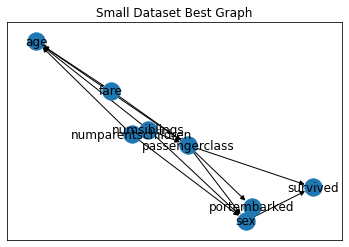

In [4]:
small = pd.read_csv("small.gph")
small_arr = np.array(small)
H = nx.DiGraph()
H.add_edges_from(small_arr)
plt.title("Small Dataset Best Graph")
nx.draw_networkx(H, with_labels = True)

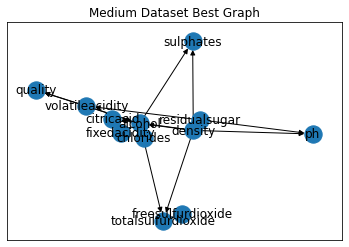

In [5]:
medium = pd.read_csv("medium.gph")
medium_arr = np.array(medium)
H = nx.DiGraph()
H.add_edges_from(medium_arr)
plt.title("Medium Dataset Best Graph")
nx.draw_networkx(H, with_labels = True)

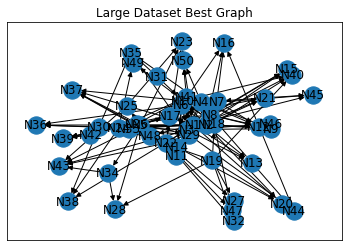

In [6]:
large = pd.read_csv("large.gph")
large_arr = np.array(large)
H = nx.DiGraph()
H.add_edges_from(large_arr)
plt.title("Large Dataset Best Graph")
nx.draw_networkx(H, with_labels = True)

## Histogram of run times
![Small Graph Search Times](C:\Users\esq60\Documents\Stanford\Courses\AA228\AA228-CS238-Student\project1\small_time.png)
![Medium Graph Search Times](C:\Users\esq60\Documents\Stanford\Courses\AA228\AA228-CS238-Student\project1\medium_time.png)
![Large Graph Search Times](C:\Users\esq60\Documents\Stanford\Courses\AA228\AA228-CS238-Student\project1\large_time.png)

\pagebreak
# Functions

### Counting Function

In [7]:
# Function to count occurances
def count_func (input_data,dag):
    
    H = dag
    d = input_data
    df_return = list()

    # For each 'node'
    for i in d.columns:
        # Find predecessors
        ls = list(H.predecessors(i))

        # If there are predecessors
        if len(ls) != 0:
            
            # Pivot along the node and parents.  Count occurrances of values.
            # Return array.
            df = pd.pivot_table(d[[i] + ls],index=ls,columns=[i],
             aggfunc=len).fillna(0).values
        else:
            # If no predecessors, count value of occurances
            d_sub = d[i].value_counts().fillna(0).values
            df = np.array(d_sub)

        #print(df)
        #print(df_return)

        # Append to list
        df_return.append(df)
    
    return df_return

### Scoring Function

In [8]:
# Calculate the Bayes Score of network
def score_func(counted_data):

    # Initialize value
    bayes_score = 0

    # For each node in the network, calculate score of counted data
    for i,m in enumerate(counted_data):

        # Instantiate alpha array.  Assuming prior is uniform, alpha = 1
        alphas = np.ones(m.shape)
        
        # If no parents (q=1), no sum along column required.
        # Calculate first part
        if m.ndim < 2:
            val_0 = (gammaln(alphas.sum()) - gammaln(alphas.sum() + m.sum())).sum()
        else:
            val_0 = (gammaln(alphas.sum(axis=1)) - gammaln(alphas.sum(axis=1) + m.sum(axis=1))).sum()

        # Calculate second part
        # Sum along rows for all r_i
        val_k = (gammaln(alphas + m) - gammaln(alphas)).sum(axis=0).sum()

        #print(val_0,val_k)

        # Sum both values and add to total score for network.
        bayes_score += (val_0 + val_k)
        #print(bayes_score)

    return bayes_score

### Search Function

In [9]:
def neighbor_search(dat,graph):

    score_bench = -math.inf
    new_val = True
    nodes = list(graph.nodes())
    graph_new = graph.copy()

    ct = 0
    
    while new_val == True:
        
        ct += 1
        i = random.sample(nodes,k=1)

        nodes_delta = nodes.copy()
        graph_delta = graph_new.copy()
        
        nodes_delta.remove(i[0])
        
        score_new = -math.inf

        for j in range(len(nodes_delta)):

           # print(list(graph_new.edges()))

            graph_delta = graph_new.copy()
            score_temp = -math.inf

            nodes_test = nodes_delta[j]
            #print(nodes_test)

            children = list(graph_new.successors(i[0]))
            parents = list(graph_new.predecessors(i[0]))


            if nodes_test in children:

                graph_delta.remove_edge(i[0],nodes_test)
                
                score_temp = score_func(count_func(dat,graph_delta))

                if nx.is_directed_acyclic_graph(graph_delta) == True:
                    score_temp = score_func(count_func(dat,graph_delta))
                else:
                    score_temp = -math.inf

                if score_temp > score_new:
                    
                    score_new = score_temp
                    graph_new = graph_delta.copy()
                else:
                    graph_delta = graph_new.copy()


                graph_delta.add_edge(nodes_test,i[0])

                if nx.is_directed_acyclic_graph(graph_delta) == True:
                    score_temp = score_func(count_func(dat,graph_delta))
                else:
                    score_temp = -math.inf

                if score_temp > score_new:
                    score_new = score_temp
                    graph_new = graph_delta.copy()
                else:
                    graph_delta = graph_new.copy()

            elif nodes_test in parents:

                graph_delta.remove_edge(nodes_test,i[0])

                if nx.is_directed_acyclic_graph(graph_delta) == True:
                    score_temp = score_func(count_func(dat,graph_delta))
                else:
                    score_temp = -math.inf

                if score_temp > score_new:
                    score_new = score_temp
                    graph_new = graph_delta.copy()
                else:
                    graph_delta = graph_new.copy()

                graph_delta.add_edge(i[0],nodes_test)

                if nx.is_directed_acyclic_graph(graph_delta) == True:
                    score_temp = score_func(count_func(dat,graph_delta))
                else:
                    score_temp = -math.inf

                if score_temp > score_new:
                    score_new = score_temp
                    graph_new = graph_delta.copy()
                else:
                    graph_delta = graph_new.copy()

            else:

                graph_delta.add_edge(nodes_test,i[0])

                if nx.is_directed_acyclic_graph(graph_delta) == True:
                    score_temp = score_func(count_func(dat,graph_delta))
                else:
                    score_temp = -math.inf

                if score_temp > score_new:
                    score_new = score_temp
                    graph_new = graph_delta.copy()

                else:
                    graph_delta = graph_new.copy()

                graph_delta.add_edge(i[0],nodes_test)

                if nx.is_directed_acyclic_graph(graph_delta) == True:
                    score_temp = score_func(count_func(dat,graph_delta))
                else:
                    score_temp = -math.inf
                

                if score_temp > score_new:
                    
                    score_new = score_temp
                    graph_new = graph_delta.copy()
                else:
                    graph_delta = graph_new.copy()
                    
        if score_new > score_bench:            
            new_val = True
            score_bench = score_new
            graph_new = graph_delta.copy()
            graph_final = graph_delta.copy()

        else:
            new_val = False
            break

    return graph_final, score_bench, ct

## Execution Code

In [10]:
d = pd.read_csv("data/small.csv")
df_vars = d.columns
# Create undirected graph
G = nx.Graph()
G.add_nodes_from(df_vars)
# Directed graph from G
H = nx.DiGraph(G)

In [11]:
def write_gph(dag, filename):
    with open(filename, 'w', newline="") as f:
        writer = csv.writer(f)
        writer.writerows(np.array(dag.edges()))

In [12]:
score_best = -math.inf
H_best = H.copy()
H_test = H.copy()
time_array = []
score_target = -3825 #

# While loop is optional.  Run if you are trying to beat a benchmark.
while score_best < score_target: # Run until you win!
    no_new = 0 

    H_best = H.copy()

    for i in range(100): # Search n times for graph initialization
        
        start_time = time.time()
        if i > 1:
            edge_len = len(list(H_best.edges()))
            smpl = random.sample(list(H_best.edges()),random.randint(int(.75*edge_len),int(.9*edge_len)))

            H_test.remove_edges_from(list(H_test.edges()))
            H_test.add_edges_from(smpl)
        
        gph_new, score_new, ct = neighbor_search(d,H_test)

        end_time = time.time()
        time_array.append(end_time-start_time)
        if score_new > score_best:
            score_best = score_new
            write_gph(gph_new,filename="graph.gph")
            H_best = gph_new
            print(i,score_best,nx.is_directed_acyclic_graph(H_best), ct)
            no_new = 0
        else:
            no_new += 1

        if i % 10 == 0:
            print("Run:",i)

        if score_best > score_target:
            write_gph(H_best,str(int(score_best))+".gph")

        if no_new > 20:
            print("No New")
            break

0 -3859.600540033856 True 8
Run: 0
1 -3845.12915201441 True 6
2 -3826.530915130036 True 4
Run: 10
16 -3814.316263127632 True 7
Run: 20
23 -3809.8748402543365 True 6
Run: 30
38 -3804.869389444343 True 6
Run: 40
Run: 50
52 -3799.48401012502 True 5
Run: 60
Run: 70
No New
